# Triples (or higher order) systems in each samples

In [1]:
import sys
sys.path.append('../src')
import os
import P_binary
import P_random
import P_posterior
import parallax
import const as c
import time
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
import corner
import pickle


%matplotlib inline

/Library/Python/2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


### Read in samples

In [14]:
dtype = [('P_posterior','f8'), ('theta','f8'),
         ('source_id_1','<i8'), ('TYC_id_1','S11'), ('hip_id_1','<i8'),
         ('ra_1','f8'), ('dec_1','f8'),
         ('mu_ra_1','f8'), ('mu_dec_1','f8'), ('mu_ra_err_1','f8'), ('mu_dec_err_1','f8'),
         ('plx_1','f8'), ('plx_err_1','f8'),
         ('gaia_g_flux_1','<f8'), ('gaia_g_flux_err_1','<f8'), ('gaia_g_mag_1','<f8'),
         ('TMASS_id_1','<i8'), ('TMASS_angle_dist_1','<f8'),
#         ('TMASS_n_neighbours_1','<i8'), ('TMASS_n_mates_1','<i8'), ('TMASS_ph_qual_1','S11'),
         ('TMASS_ra_1','<f8'), ('TMASS_dec_1','<f8'),
         ('TMASS_j_mag_1','<f8'), ('TMASS_j_mag_err_1','<f8'),
         ('TMASS_h_mag_1','<f8'), ('TMASS_h_mag_err_1','<f8'),
         ('TMASS_ks_mag_1','<f8'), ('TMASS_ks_mag_err_1','<f8'),
         ('TYC_Vt_1','<f8'), ('TYC_Vt_err_1','<f8'),
         ('TYC_Bt_1','<f8'), ('TYC_Bt_err_1','<f8'),
         ('gaia_delta_Q_1','<f8'), ('gaia_noise_1','<f8'),
         #
         ('source_id_2','<i8'), ('TYC_id_2','S11'), ('hip_id_2','<i8'),
         ('ra_2','f8'), ('dec_2','f8'),
         ('mu_ra_2','f8'), ('mu_dec_2','f8'), ('mu_ra_err_2','f8'), ('mu_dec_err_2','f8'),
         ('plx_2','f8'), ('plx_err_2','f8'),
         ('gaia_g_flux_2','<f8'), ('gaia_g_flux_err_2','<f8'), ('gaia_g_mag_2','<f8'),
         ('TMASS_id_2','<i8'), ('TMASS_angle_dist_2','<f8'),
#         ('TMASS_n_neighbours_2','<i8'), ('TMASS_n_mates_2','<i8'), ('TMASS_ph_qual_2','S11'),
         ('TMASS_ra_2','<f8'), ('TMASS_dec_2','<f8'),
         ('TMASS_j_mag_2','<f8'), ('TMASS_j_mag_err_2','<f8'),
         ('TMASS_h_mag_2','<f8'), ('TMASS_h_mag_err_2','<f8'),
         ('TMASS_ks_mag_2','<f8'), ('TMASS_ks_mag_err_2','<f8'),
         ('TYC_Vt_2','<f8'), ('TYC_Vt_err_2','<f8'),
         ('TYC_Bt_2','<f8'), ('TYC_Bt_err_2','<f8'),
         ('gaia_delta_Q_2','<f8'), ('gaia_noise_2','<f8')
        ]

folder = '../data/TGAS/'

TGAS_power_law = np.genfromtxt(folder+'gaia_wide_binaries_TGAS_plx_exponential_a_power_law_cleaned.txt', dtype=dtype, names=True)
TGAS_log_flat = np.genfromtxt(folder+'gaia_wide_binaries_TGAS_plx_exponential_cleaned.txt', dtype=dtype, names=True)

TGAS_power_law_good = TGAS_power_law[TGAS_power_law['P_posterior'] > 0.99]
TGAS_log_flat_good = TGAS_log_flat[TGAS_log_flat['P_posterior'] > 0.99]

### First, NLTT matches

In [2]:
# Full NLTT Catalog
filename = ('../data/rNLTT/catalog_tabs.dat')
t_full = Table.read(filename, format='ascii', guess=True)

# Change proper motion units from asec/yr to mas/yr
t_full['mu_ra'] = 1.0e3*t_full['mu_ra']
t_full['mu_dec'] = 1.0e3*t_full['mu_dec']
t_full['mu_ra_err'] = 1.0e3*t_full['mu_ra_err']
t_full['mu_dec_err'] = 1.0e3*t_full['mu_dec_err']

# Select only stars with proper motion uncertainties greater than 0.1 mas/yr - remove junk
ids_good = np.intersect1d(np.where(t_full['mu_ra_err'] >= 0.1), np.where(t_full['mu_dec_err'] >= 0.1))
t = t_full[ids_good]
print t.dtype

[('NLTT', '<i8'), ('ra', '<f8'), ('dec', '<f8'), ('mu_ra', '<f8'), ('mu_dec', '<f8'), ('mu_ra_err', '<f8'), ('mu_dec_err', '<f8'), ('HIP', '<i8'), ('V', '<f8'), ('B', '<f8'), ('R', '<f8'), ('J', '<f8'), ('H', '<f8'), ('K', '<f8')]


In [3]:
# Now read in matched pairs
NLTT_prob = pickle.load( open("../data/rNLTT/prob_out.data", "rb"))
print NLTT_prob.dtype

[('i_1', '<i4'), ('i_2', '<i4'), ('ID_1', '<i4'), ('ID_2', '<i4'), ('P_random', '<f8'), ('P_binary', '<f8'), ('P_posterior', '<f8')]


### TGAS matches

In [2]:
# Read in sample from TGAS table
dtype = [('ID','<i8'),('tyc','S11'),('hip','<i8'),('ra','<f8'),('dec','<f8'),('mu_ra','<f8'),('mu_dec','<f8'), \
     ('mu_ra_err','<f8'),('mu_dec_err','<f8'),('plx','<f8'),('plx_err','<f8')]

tgas_full = np.array([], dtype=dtype)

for i in np.arange(1):
    if i < 10:
        filename = ('../data/TGAS/TgasSource_000-000-00' + str(i) + '.csv')
    else:
        filename = ('../data/TGAS/TgasSource_000-000-0' + str(i) + '.csv')

    print filename
    tgas_tmp = Table.read(filename, format='csv', guess=True)
    
    

    tgas = np.zeros(len(tgas_tmp), dtype=dtype)

    tgas['ID'] = tgas_tmp['source_id']
    tgas['tyc'] = tgas_tmp['tycho2_id']
    tgas['hip'] = tgas_tmp['hip']
    tgas['ra'] = tgas_tmp['ra']
    tgas['dec'] = tgas_tmp['dec']
    tgas['mu_ra'] = tgas_tmp['pmra']
    tgas['mu_ra_err'] = tgas_tmp['pmra_error']
    tgas['mu_dec'] = tgas_tmp['pmdec']
    tgas['mu_dec_err'] = tgas_tmp['pmdec_error']
    tgas['plx'] = tgas_tmp['parallax']
    tgas['plx_err'] = tgas_tmp['parallax_error']

    tgas_full = np.append(tgas_full, tgas)



../data/TGAS/TgasSource_000-000-000.csv


In [3]:
idx_max = len(tgas_full)
print idx_max

134865


In [10]:
TGAS_prob_tmp = pickle.load( open("../data/TGAS/TGAS_plx_exponential_141.p", "rb"))

TGAS_prob = np.array([], dtype=TGAS_prob_tmp.dtype)

directory = "../data/TGAS/"
for filename in os.listdir(directory):
    if filename.endswith(".p"):
        TGAS_prob_tmp = pickle.load( open(directory+filename, "rb"))
        TGAS_prob = np.append(TGAS_prob, TGAS_prob_tmp)

print TGAS_prob.dtype

TGAS_good = TGAS_prob[TGAS_prob['P_posterior'] > 0.99]
print len(TGAS_prob), len(TGAS_good)

[('i_1', '<i4'), ('i_2', '<i4'), ('ID_1', '<i4'), ('ID_2', '<i4'), ('P_random', '<f8'), ('P_binary', '<f8'), ('P_posterior', '<f8'), ('theta', '<f8'), ('mu_ra_1', '<f8'), ('mu_dec_1', '<f8'), ('mu_ra_2', '<f8'), ('mu_dec_2', '<f8'), ('plx_1', '<f8'), ('plx_2', '<f8')]
44012 893


In [126]:
def find_multiples(catalog):
    
    triple_pairs, triple_angles, quad_pairs, quad_angles, quint_pairs, quint_angles = match_multiple_IDs(catalog)
    
#     triple_angles = get_triple_angles(triple_pairs)
    
    return triple_pairs, quad_pairs, quint_pairs
    
    
    
def match_multiple_IDs(catalog):

    dtype_3 = ([('i_1', 'i8'), ('i_2', 'i8'), ('i_3', 'i8')])
    dtype_3_angles = ([('theta_1', 'f8'), ('theta_2', 'f8')])
    dtype_4 = ([('i_1', 'i8'), ('i_2', 'i8'), ('i_3', 'i8'), ('i_4', 'i8')])
    dtype_4_angles = ([('theta_1', 'f8'), ('theta_2', 'f8'), ('theta_3', 'f8')])
    dtype_5 = ([('i_1', 'i8'), ('i_2', 'i8'), ('i_3', 'i8'), ('i_4', 'i8'), ('i_5', 'i8')])
    dtype_5_angles = ([('theta_1', 'f8'), ('theta_2', 'f8'), ('theta_3', 'f8'), ('theta_4', 'f8')])
    dtype_6 = ([('i_1', 'i8'), ('i_2', 'i8'), ('i_3', 'i8'), ('i_4', 'i8'), ('i_5', 'i8'), ('i_6', 'i8')])
    dtype_6_angles = ([('theta_1', 'f8'), ('theta_2', 'f8'), ('theta_3', 'f8'), ('theta_4', 'f8'), ('theta_5', 'f8')])

    
    triple_pairs = np.array([], dtype=dtype_3)
#     triple_angles = np.array([], dtype=dtype_3_angles)
    triple_angles = np.array([])
    quad_pairs = np.array([], dtype=dtype_4)
#     quad_angles = np.array([], dtype=dtype_4_angles)
    quad_angles = np.array([])
    quint_pairs = np.array([], dtype=dtype_5)
#     quint_angles = np.array([], dtype=dtype_5_angles)
    quint_angles = np.array([])
    sex_pairs = np.array([], dtype=dtype_6)
#     sex_angles = np.array([], dtype=dtype_6_angles)
    sex_angles = np.array([])
    
    higher_order = np.array([])
    
    N_triple = 0
    for i in np.arange(len(catalog)-1):
        
        if i%1000 == 0: print i
        
#         # Make sure we don't go beyond the bounds of the subset of the TGAS catalog we are testing
#         if catalog['i_1'][i] > idx_max or catalog['i_2'][i] > idx_max: continue
            
#         # Only select pairs with a posterior probability above 50%
#         if catalog['P_posterior'][i] < 0.9: continue
            
        # Check to make sure entry has not already been identified as part of a multiple system
        matched = False
        for pair in triple_pairs:
            if np.any(pair['i_1'] == catalog['source_ID_1'][i]) or \
               np.any(pair['i_2'] == catalog['source_ID_1'][i]) or \
               np.any(pair['i_3'] == catalog['source_ID_1'][i]) or \
               np.any(pair['i_1'] == catalog['source_ID_2'][i]) or \
               np.any(pair['i_2'] == catalog['source_ID_2'][i]) or \
               np.any(pair['i_3'] == catalog['source_ID_2'][i]):
                matched = True
        for pair in quad_pairs: 
            if np.any(pair['i_1'] == catalog['source_ID_1'][i]) or \
               np.any(pair['i_2'] == catalog['source_ID_1'][i]) or \
               np.any(pair['i_3'] == catalog['source_ID_1'][i]) or \
               np.any(pair['i_4'] == catalog['source_ID_1'][i]) or \
               np.any(pair['i_1'] == catalog['source_ID_2'][i]) or \
               np.any(pair['i_2'] == catalog['source_ID_2'][i]) or \
               np.any(pair['i_3'] == catalog['source_ID_2'][i]) or \
               np.any(pair['i_4'] == catalog['source_ID_2'][i]):
                matched = True
        for pair in quint_pairs: 
            if np.any(pair['i_1'] == catalog['source_ID_1'][i]) or \
               np.any(pair['i_2'] == catalog['source_ID_1'][i]) or \
               np.any(pair['i_3'] == catalog['source_ID_1'][i]) or \
               np.any(pair['i_4'] == catalog['source_ID_1'][i]) or \
               np.any(pair['i_5'] == catalog['source_ID_1'][i]) or \
               np.any(pair['i_1'] == catalog['source_ID_2'][i]) or \
               np.any(pair['i_2'] == catalog['source_ID_2'][i]) or \
               np.any(pair['i_3'] == catalog['source_ID_2'][i]) or \
               np.any(pair['i_4'] == catalog['source_ID_2'][i]) or \
               np.any(pair['i_5'] == catalog['source_ID_2'][i]):
                matched = True
        for pair in sex_pairs: 
            if np.any(pair['i_1'] == catalog['source_ID_1'][i]) or \
               np.any(pair['i_2'] == catalog['source_ID_1'][i]) or \
               np.any(pair['i_3'] == catalog['source_ID_1'][i]) or \
               np.any(pair['i_4'] == catalog['source_ID_1'][i]) or \
               np.any(pair['i_5'] == catalog['source_ID_1'][i]) or \
               np.any(pair['i_6'] == catalog['source_ID_1'][i]) or \
               np.any(pair['i_1'] == catalog['source_ID_2'][i]) or \
               np.any(pair['i_2'] == catalog['source_ID_2'][i]) or \
               np.any(pair['i_3'] == catalog['source_ID_2'][i]) or \
               np.any(pair['i_4'] == catalog['source_ID_2'][i]) or \
               np.any(pair['i_5'] == catalog['source_ID_2'][i]) or \
               np.any(pair['i_6'] == catalog['source_ID_2'][i]):
                matched = True

        if matched: continue
            
            
        
        # Look for matching indices
        i2 = np.arange(len(catalog) - i - 1) + i + 1
        idx = np.array([], dtype='i8')
        thetax = np.array([catalog['theta'][i]], dtype='f8')
        
        for j in i2:
                        
#             # Make sure we don't go beyond the bounds of the subset of the TGAS catalog we are testing
#             if catalog['source_id_1'][j] > idx_max or catalog['source_id_2'][j] > idx_max: continue

#             # Only select pairs with a posterior probability above 50%
#             if catalog['P_posterior'][j] < 0.5: continue

            if catalog['source_ID_1'][j] == catalog['source_ID_1'][i] \
               or catalog['source_ID_1'][j] == catalog['source_ID_2'][i] \
               or catalog['source_ID_2'][j] == catalog['source_ID_1'][i] \
               or catalog['source_ID_2'][j] == catalog['source_ID_2'][i]:
                    
                        
                # Default is to add the entry
                match_1 = True
                match_2 = True

            
                if not np.any(idx == catalog['source_ID_1'][i]): idx = np.append(idx, catalog['source_ID_1'][i])
                if not np.any(idx == catalog['source_ID_2'][i]): idx = np.append(idx, catalog['source_ID_2'][i])
                if not np.any(idx == catalog['source_ID_1'][j]): idx = np.append(idx, catalog['source_ID_1'][j])
                if not np.any(idx == catalog['source_ID_2'][j]): idx = np.append(idx, catalog['source_ID_2'][j])
                
#                 print catalog['theta'][j]
                thetax = np.append(thetax, catalog['theta'][j])
#                 print thetax
                
#         if len(idx) > 2:
#             print thetax
            
        if len(idx) == 3:
            triple_pairs = np.append(triple_pairs, np.array([(idx[0], idx[1], idx[2])], dtype=dtype_3))
            triple_tmp = np.array([thetax[0], thetax[1]])
            if len(triple_angles) == 0:
                triple_angles = triple_tmp
            elif len(triple_angles) == 1:
                triple_angles = np.stack((triple_angles, triple_tmp))
            else:
                triple_angles = np.vstack((triple_angles, triple_tmp))
                
        if len(idx) == 4:
            quad_pairs = np.append(quad_pairs, np.array([(idx[0], idx[1], idx[2], idx[3])], dtype=dtype_4))
            quad_tmp = np.array([thetax[0], thetax[1], thetax[2]])
            if len(quad_angles) == 0:
                quad_angles = quad_tmp
            elif len(quad_angles) == 1:
                quad_angles = np.stack((quad_angles, quad_tmp))
            else:
                quad_angles = np.vstack((quad_angles, quad_tmp))

#             quad_angles = np.append(quad_angles, np.array([thetax[0], thetax[1], thetax[2]]))

        if len(idx) == 5:
            quint_pairs = np.append(quint_pairs, np.array([(idx[0], idx[1], idx[2], idx[3], idx[4])], dtype=dtype_5))
            quint_tmp = np.array([thetax[0], thetax[1], thetax[2], thetax[3]])
            if len(quint_angles) == 0:
                quint_angles = quint_tmp
            elif len(quint_angles) == 1:
                quint_angles = np.stack((quint_angles, quint_tmp))
            else:
                quint_angles = np.vstack((quint_angles, quint_tmp))

#             quint_angles = np.append(quint_angles, np.array([thetax[0], thetax[1], thetax[2], thetax[3]]))

        if len(idx) == 6:
            sex_pairs = np.append(sex_pairs, np.array([(idx[0], idx[1], idx[2], idx[3], idx[4], idx[5])], dtype=dtype_6))
            sex_tmp = np.array([thetax[0], thetax[1], thetax[2], thetax[3], thetax[4]])
            if len(sex_angles) == 0:
                sex_angles = sex_tmp
            elif len(sex_angles) == 1:
                sex_angles = np.stack((sex_angles, sex_tmp))
            else:
                sex_angles = np.vstack((sex_angles, sex_tmp))

#             sex_angles = np.append(sex_angles, np.array([thetax[0], thetax[1], thetax[2], thetax[3], thetax[4]]))

        if len(idx) > 6:
            higher_order = np.append(higher_order, len(idx))



    return triple_pairs, triple_angles, quad_pairs, quad_angles, quint_pairs, quint_angles, sex_pairs, sex_angles, higher_order



def get_triple_angles(triple_pairs):
    
    dtype_angle_3 = ([('theta_1', 'f8'), ('theta_2', 'f8'), ('theta_3', 'f8')])
    triple_angles = np.array([], dtype=dtype_angle_3)
    
    for idx in triple_pairs:
        
        angle1 = 3600.0 * P_random.get_theta_proj_degree(tgas_full[idx[0]]['ra'], tgas_full[idx[0]]['dec'], 
                                                         tgas_full[idx[1]]['ra'], tgas_full[idx[1]]['dec'])
        angle2 = 3600.0 * P_random.get_theta_proj_degree(tgas_full[idx[0]]['ra'], tgas_full[idx[0]]['dec'], 
                                                         tgas_full[idx[2]]['ra'], tgas_full[idx[2]]['dec'])
        angle3 = 3600.0 * P_random.get_theta_proj_degree(tgas_full[idx[1]]['ra'], tgas_full[idx[1]]['dec'], 
                                                         tgas_full[idx[2]]['ra'], tgas_full[idx[2]]['dec'])
        
        triple_angles = np.append(triple_angles, np.array([(angle1, angle2, angle3)], dtype=dtype_angle_3))
        
        
    return triple_angles

In [127]:
triple_pairs, triple_angles, quad_pairs, quad_angles, quint_pairs, quint_angles, \
        sex_pairs, sex_angles, higher_order = match_multiple_IDs(TGAS_power_law_good)
# triple_pairs, quad_pairs, quint_pairs = find_multiples(TGAS_power_law_good)

0
1000
2000
3000
4000


In [131]:
print len(triple_pairs)
print len(quad_pairs)
print len(quint_pairs)
print len(sex_pairs)
print higher_order

print triple_angles[0]
print quad_angles[0]
print quint_angles[0]
print sex_angles[0]

55
9
1
1
[]
[ 134.47  470.02]
[ 1470.81  1620.35   175.47]
627.36
854.33


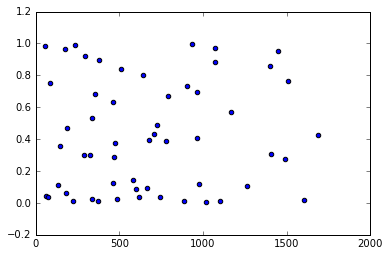

In [145]:
ratio = np.min(triple_angles.T, axis=0) / np.max(triple_angles.T, axis=0)

plt.scatter(np.max(triple_angles.T, axis=0), ratio)
plt.xlim(0, 2000)
# plt.ylim(0, 1600)

# plt.plot([0.0, 2000.0], [0.0, 2000.0], color='k')

# plt.gca().set_aspect('equal', adjustable='box')
plt.show()

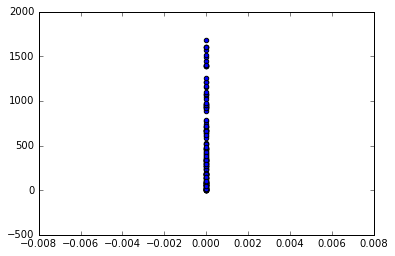

In [50]:
for i in np.arange(len(triple_angles)):
    plt.scatter(min(triple_angles[i]), max(triple_angles[i]))

plt.show()

angle_min = np.zeros(len(triple_angles))
angle_max = np.zeros(len(triple_angles))

for i, angle in zip(np.arange(len(triple_angles)), triple_angles):
    angle_min[i] = np.min([angle['theta_1'], angle['theta_2'], angle['theta_3']])
    angle_max[i] = np.max([angle['theta_1'], angle['theta_2'], angle['theta_3']])

    
plt.scatter(angle_max, angle_min)

plt.xlim(0.0, 1400)
plt.ylim(0.0, 1400)

plt.show()

In [15]:
print triple_pairs
print
print quad_pairs
print
print quint_pairs

[]

[]

[]


In [19]:
for i in np.arange(len(TGAS_good)):
    print TGAS_good[i]['mu_ra_1'], TGAS_good[i]['mu_dec_1'], TGAS_good[i]['plx_1']

21.7213497823 -34.2291525182 3.37970135266
33.1987044974 -22.9906810827 2.90354506924
34.9555033702 0.745237679416 4.55273042941
0.622408622179 7.0884802395 3.17169601185
19.4789707037 2.91844666281 4.48402686181
19.4789707037 2.91844666281 4.48402686181
19.4789707037 2.91844666281 4.48402686181
49.0104481484 -12.9962556587 7.74134071428
-10.6270897932 -5.81135306586 2.95487085528
82.2203814814 18.1521921254 10.4412651736
10.4696495647 -16.3192742249 1.69537251563
30.8695455119 -13.7631503297 6.27624710773
17.5748530158 3.5463004555 4.14707417093
17.5748530158 3.5463004555 4.14707417093
17.5748530158 3.5463004555 4.14707417093
17.5748530158 3.5463004555 4.14707417093
17.5748530158 3.5463004555 4.14707417093
17.5748530158 3.5463004555 4.14707417093
17.5748530158 3.5463004555 4.14707417093
17.5748530158 3.5463004555 4.14707417093
20.1391653294 2.0401390724 3.91872688154
20.1391653294 2.0401390724 3.91872688154
20.1391653294 2.0401390724 3.91872688154
20.1391653294 2.0401390724 3.91872688